# FreeWheel Logo Detection模型Pipeline构建

## 0. 准备和初始化

第一步工作是安装step functions data scientist SDK，这个SDK能简化构建step functions工作流的复杂度，以编程的方式构建，而不是通过传统的编写SFN的ASL语言的方式。

In [1]:
import sys
!{sys.executable} -m pip install --upgrade stepfunctions 1>/dev/null

第二步是准备好训练用的数据，为了可以更快速的验证和调试step function，我们对logo3k和fw5k数据做一些抽样话处理
下述步骤是为了准备好基础训练（logo3k）和增量训练（fw5k）的数据，如果你有自己的数据，请按照如下的s3目录结构组织起来：

YOUR_S3_BUCKET  
$~~~~~~~~~$|──LogoDet-3K/      
$~~~~~~~~~$$~~~~~~~~~$|── cfg/    
$~~~~~~~~~$$~~~~~~~~~$|── datasets/    
$~~~~~~~~~$$~~~~~~~~~$|$~~~~~~~~~$|── images/     
$~~~~~~~~~$$~~~~~~~~~$│$~~~~~~~~~$|$~~~~~~~~~$|── train/     
$~~~~~~~~~$$~~~~~~~~~$|$~~~~~~~~~$|$~~~~~~~~~$|── val/     
$~~~~~~~~~$$~~~~~~~~~$|$~~~~~~~~~$|── labels/     
$~~~~~~~~~$$~~~~~~~~~$|$~~~~~~~~~$$~~~~~~~~~~$|── train/   
$~~~~~~~~~$$~~~~~~~~~$|$~~~~~~~~~$$~~~~~~~~~~$|── val/   
$~~~~~~~~~$$~~~~~~~~~$|── weights/  

以上图为例，只要保证“LogoDet-3K”及一下层级按照此结构组织就好，如果数据已准备好请跳过如下数据准备的步骤

In [14]:
'''
单独创建一个文件夹pipeline-exp-data，用于存放调试sfn所用的数据训练数据
'''
!rm -rf pipeline-exp-data

!mkdir -p pipeline-exp-data/LogoDet-3K/datasets/images/train
!mkdir -p pipeline-exp-data/LogoDet-3K/datasets/images/val
!mkdir -p pipeline-exp-data/LogoDet-3K/datasets/labels/train
!mkdir -p pipeline-exp-data/LogoDet-3K/datasets/labels/val
!mkdir -p pipeline-exp-data/LogoDet-3K/cfg/

!mkdir -p pipeline-exp-data/FreeWheel-5K-by-video-name/datasets/images/train
!mkdir -p pipeline-exp-data/FreeWheel-5K-by-video-name/datasets/images/val
!mkdir -p pipeline-exp-data/FreeWheel-5K-by-video-name/datasets/labels/train
!mkdir -p pipeline-exp-data/FreeWheel-5K-by-video-name/datasets/labels/val
!mkdir -p pipeline-exp-data/FreeWheel-5K-by-video-name/cfg/


准备logo3k实验数据

In [8]:
'''
准备logo3k实验数据, 除了设置了抽样率，其他逻辑和《FreeWheel Logo Detection模型训练指导》无异
'''
import os
import shutil
import xmltodict
from tqdm import tqdm

class_names_map = {'logo': 0}

DET_DATA_DIR = 'pipeline-exp-data'
LD3K_DATA_DIR = DET_DATA_DIR + '/' + 'LogoDet-3K'
LD3K_DS_DIR = LD3K_DATA_DIR + '/' + 'datasets'
RAW_LD3K_DS_DIR = 'raw_data/LogoDet-3K' # 如果raw_data中没有数据，请重新运行一下logodet-prep.sh
sample_rate = 0.01 # 设置抽样率

In [15]:
sub_dirs = os.listdir(RAW_LD3K_DS_DIR)
for sub_dir in tqdm(sub_dirs):
    if 'DS_Store' not in sub_dir:
        sub_sub_dirs = os.listdir(os.path.join(RAW_LD3K_DS_DIR, sub_dir))
        for sub_sub_dir in sub_sub_dirs:
            if 'DS_Store' not in sub_sub_dir:
                filenames = os.listdir(os.path.join(RAW_LD3K_DS_DIR, sub_dir, sub_sub_dir))
                i = 0
                for filename in filenames:
                    if i > int(len(filenames) * sample_rate):
                        break
                    old_filename = os.path.join(RAW_LD3K_DS_DIR, sub_dir, sub_sub_dir, filename)
                    if filename.endswith('xml'):
                        old_image_filename = os.path.join(RAW_LD3K_DS_DIR, sub_dir, sub_sub_dir, filename.replace('xml', 'jpg'))
                        #print(old_image_filename)
                        new_image_filename = os.path.join(LD3K_DS_DIR, 'images/train', sub_dir+'_'+sub_sub_dir+'_'+filename.replace('xml', 'jpg'))
                        #print(new_image_filename)
                        shutil.copy(old_image_filename, new_image_filename)
                        
                        new_filename = os.path.join(LD3K_DS_DIR, 'labels/train', sub_dir+'_'+sub_sub_dir+'_'+filename.replace('xml', 'txt'))
                        file_object = open(old_filename, encoding='utf-8')                                                                                                            
                        try:
                            all_the_xmlStr = file_object.read()
                        finally:
                            file_object.close()
                        convertedDict = xmltodict.parse(all_the_xmlStr)
                #         print(len(convertedDict['annotation']['object']))
                        if 'object' in convertedDict['annotation']:
                            fix_width = int(convertedDict['annotation']['size']['width'])
                            fix_height = int(convertedDict['annotation']['size']['height'])
                            
                            objs = convertedDict['annotation']['object']
                            if not isinstance(objs,list):
                                objs = [objs]
                #                 print('objs:', objs)
                            with open(new_filename, 'w') as fout:
                                for annotation in objs:
                                    # class_id = 0
                                    if annotation['name'] not in class_names_map:
                                        class_names_map[annotation['name']] = len(class_names_map)
                                    class_id = class_names_map[annotation['name']]

                                    xmin = int(annotation['bndbox']['xmin'])
                                    ymin = int(annotation['bndbox']['ymin'])
                                    xmax = int(annotation['bndbox']['xmax'])
                                    ymax = int(annotation['bndbox']['ymax'])

                                    w = xmax-xmin
                                    h = ymax-ymin

                                    if w>0 and h>0:
                                        center_x = (xmin+xmax)/2
                                        center_y = (ymin+ymax)/2
                                        fout.write(str(class_id)+' '+str(center_x/fix_width)+' '+str(center_y/fix_height)+' '+str(w/fix_width)+' '+str(h/fix_height)+'\n')
                                        fout.write(str(0)+' '+str(center_x/fix_width)+' '+str(center_y/fix_height)+' '+str(w/fix_width)+' '+str(h/fix_height)+'\n')
                        else:
                            print('Delete', old_filename)
                            os.remove(old_filename)
                    elif filename.endswith('jpg'):
                        pass
                        
                    else:
                        print('Warning:', old_filename)
                    i = i + 1

100%|██████████| 9/9 [00:01<00:00,  7.62it/s]


In [16]:
import os
from sklearn.model_selection import train_test_split

filenames = os.listdir(os.path.join(LD3K_DS_DIR, 'images/train'))
train_filenames, test_filenames = train_test_split(filenames, test_size=0.2)
print(len(filenames), len(train_filenames), len(test_filenames))
for filename in tqdm(test_filenames):
    old_filename = os.path.join(LD3K_DS_DIR, 'images/train', filename)
    new_filename = os.path.join(LD3K_DS_DIR, 'images/val', filename)
    shutil.move(old_filename, new_filename)
    
    old_filename = os.path.join(LD3K_DS_DIR, 'labels/train', filename.replace('jpg', 'txt'))
    new_filename = os.path.join(LD3K_DS_DIR, 'labels/val', filename.replace('jpg', 'txt'))
    if os.path.exists(old_filename):
        shutil.move(old_filename, new_filename)
    else:
        print('Not exist:', old_filename)

2922 2337 585


100%|██████████| 585/585 [00:00<00:00, 29263.28it/s]


In [17]:
print('class_names_map:', len(class_names_map))

cfg_path = os.path.join(LD3K_DATA_DIR, 'cfg', 'LogoDet-3K.yaml')
with open(cfg_path, 'w') as fout:
    fout.write('path: ' + '/opt/ml/input/data/training/' + '  # dataset root dir\n')
    fout.write('train: datasets/images/train  # train images (relative to \'path\')\n')
    fout.write('val: datasets/images/val  # val images (relative to \'path\')\n')
    fout.write('test:  # test images (optional)\n')
    fout.write('names:\n')
    for k,v in class_names_map.items():
        fout.write('  '+str(v)+': '+str(k)+'\n')

class_names_map: 2217


准备fw5k实验数据，因为fw5k数据集规模比较小，没有做抽样

In [22]:
!cp -r raw_data/image-data-4.28/images/*.jpg pipeline-exp-data/FreeWheel-5K-by-video-name/datasets/images/train
!cp -r raw_data/image-data-4.28/labels/*.txt pipeline-exp-data/FreeWheel-5K-by-video-name/datasets/labels/train

In [23]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_dir = 'pipeline-exp-data/FreeWheel-5K-by-video-name/datasets/images/train'
filenames = os.listdir(base_dir)
video_names = {}
for filename in filenames:
    video_name = filename.split('#')[0]
    if video_name not in video_names:
        video_names[video_name] = []
    video_names[video_name].append(filename)
print('video_names:', len(video_names))

video_names: 1182


In [24]:
train_video_names, val_video_names = train_test_split(list(video_names.keys()), test_size=0.2)
for video_name in val_video_names:
    val_filenames = video_names[video_name]
    for filename in val_filenames:
        if filename.endswith('jpg'):
            filename = os.path.join(base_dir, filename)
            shutil.move(filename, filename.replace('images/train', 'images/val'))
            label_filename = filename.replace('jpg', 'txt').replace('images', 'labels')
            if os.path.exists(label_filename):
                shutil.move(label_filename, label_filename.replace('labels/train', 'labels/val'))
print(len(train_video_names), len(val_video_names))

945 237


In [25]:
class_names_map = {}

with open('raw_data/image-data-4.28/labels.txt', 'r') as fin:
    lines = fin.readlines()
    for i, line in enumerate(lines):
        class_names_map[line.strip()] = i

with open('pipeline-exp-data/FreeWheel-5K-by-video-name/cfg/FreeWheel-5K-by-video-name.yaml', 'w') as fout:
    fout.write('path: /opt/ml/input/data/training/  # dataset root dir\n')
    fout.write('train: datasets/images/train  # train images (relative to \'path\')\n')
    fout.write('val: datasets/images/val  # val images (relative to \'path\')\n')
    fout.write('test:  # test images (optional)\n')
    fout.write('names:\n')
    for k,v in class_names_map.items():
        fout.write('  '+str(v)+': '+str(k)+'\n')

最后上传logo3k和fw5k数据集到S3上

In [26]:
%env TRN_BUCKET=logo-detection-data

#!aws s3api put-object --bucket $TRN_BUCKET --key $PRE
#!docker run --rm -v $(pwd):/aws -v ~/.aws:/root/.aws s5cmd rm s3://$TRN_BUCKET/* 1>/dev/null
!docker run --rm -v $(pwd):/aws -v ~/.aws:/root/.aws s5cmd sync /aws/pipeline-exp-data s3://$TRN_BUCKET/ 1>/dev/null

env: TRN_BUCKET=logo-detection-data


## 1. 准备Sagemaker训练任务  
这一步的主要目的是通过sagemaker sdk创建对应的训练estimation对象，这些对象在后边会被step functions的training step引用

创建基础（logo3k）训练任务，也就是estimator

In [412]:
import os
import sagemaker
print(sagemaker.__version__)

from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel

sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()

2.146.0


In [413]:
TRN_BUCKET='logo-detection-data'

# logo3k在本地的目录
DET_DATA_DIR = 'pipeline-exp-data'
LD3K_DATA_DIR = DET_DATA_DIR + '/' + 'LogoDet-3K'
# logo3k在s3上的prefix和本地目录结构一致
LD3K_PRE=LD3K_DATA_DIR
base_data_location = 's3://{}/{}'.format(TRN_BUCKET, LD3K_PRE)
base_inputs = base_data_location
# 这个s3地址未来会作为pipeline的input，传递给step functions
print(base_inputs)

s3://logo-detection-data/pipeline-exp-data/LogoDet-3K


In [414]:
'''
这里训练的input和《FreeWheel Logo Detection模型训练指导》中有些差异
为了满足step function的input规范，这里我们只会传入一个训练数据的prefix，而不会按照cfg，weight，datasets组织channel
'''
base_hyperparameters = {'data': '/opt/ml/input/data/training/cfg/LogoDet-3K.yaml', 
                   'weight': 'yolov8s.pt',
                   'project': '/opt/ml/model/',
                   'name': 'fw-logo-detection', 'imgsz': 640, 'batch': 4, 'epochs': 1, 'workers':1}  # Single CPU or GPU
                   # 'name': 'fw-logo-detection', 'imgsz': 640, 'batch': 16, 'epochs': 1, 'device': '0,1,2,3', 'workers':1}  # Multi-GPU: DP Mode

base_instance_type = 'ml.p3.2xlarge'  # 'ml.p3.2xlarge' or 'ml.p3.8xlarge' or ...


base_metric_definitions = [{'Name': 'mAP50',
                       'Regex': '^all\s+(?:[\d.]+\s+){4}([\d.]+)'}]

base_estimator = PyTorch(entry_point='train.py',
                            source_dir='./code/',
                            role=role,
                            hyperparameters=base_hyperparameters,
                            framework_version='1.13.1',
                            py_version='py39',
                            script_mode=True,
                            instance_count=1,  # 1 or 2 or ...
                            metric_definitions=base_metric_definitions,
                            instance_type=base_instance_type,
                            # distribution={
                            #     "torch_distributed": {
                            #         "enabled": True
                            #     }
                            # }
            )

# base_estimator.fit(base_inputs)

创建增量（fw5k）训练任务的estimator

In [415]:
DET_DATA_DIR = 'pipeline-exp-data'
FW5K_DATA_DIR = DET_DATA_DIR + '/' + 'FreeWheel-5K-by-video-name'
FW5K_DS_DIR = FW5K_DATA_DIR + '/' + 'datasets'

TRN_BUCKET = 'logo-detection-data'
# PRE='fw-logo-detection'
FW5K_PRE = FW5K_DATA_DIR
incremental_data_location = 's3://{}/{}'.format(TRN_BUCKET, FW5K_PRE)
incremental_inputs = incremental_data_location
print(str(incremental_inputs))

s3://logo-detection-data/pipeline-exp-data/FreeWheel-5K-by-video-name


In [416]:
incremental_hyperparameters = {'data': '/opt/ml/input/data/training/cfg/FreeWheel-5K-by-video-name.yaml', 
                   'weight': '/opt/ml/input/data/training/weights/yolov8s.pt',
                   'project': '/opt/ml/model/',
                   'name': 'fw-logo-detection', 'imgsz': 640, 'batch': 4, 'epochs': 1}  # Single CPU or GPU
#                    'name': 'fw-logo-detection', 'imgsz': 640, 'batch': 16, 'epochs': 5, 'device': '0,1,2,3'}  # Multi-GPU: DP Mode

incremental_instance_type = 'ml.p3.2xlarge'  # 'ml.p3.2xlarge' or 'ml.p3.8xlarge' or ...


incremental_metric_definitions = [{'Name': 'mAP50',
                       'Regex': '^all\s+(?:[\d.]+\s+){4}([\d.]+)'}]

incremental_estimator = PyTorch(entry_point='train.py',
                            source_dir='./code/',
                            role=role,
                            hyperparameters=incremental_hyperparameters,
                            framework_version='1.13.1',
                            py_version='py39',
                            script_mode=True,
                            instance_count=1,  # 1 or 2 or ...
                            metric_definitions=incremental_metric_definitions,
                            instance_type=incremental_instance_type)

# incremental_estimator.fit(incremental_inputs)

## 2. 部署Pipeline中需要使用的lambda function  

在此步中我们将创建3个lambda function，他们的介绍和作用如下：
- **weight helper**  
由于我们有可能从一个基础训练开始，然后完成增量训练，因此这里需要将基础训练的结果best.pt下载解压并上传到增量训练需要用到的数据目录中
- **query training metrics**  
增量训练结束后我们需要确认模型的性能是否能满足需求，因此需要这个function去查询mAP50的metrics，并作为output返回给step functions
- **model wrapper**  
因为我们使用了自定义的inference.py文件，所以我们需要对增量训练的结果best.pt和inference.py文件进行打包上传到s3，用于之后推理服务器的使用

部署这三个lambda需要安装AWS SAM CLI，安装步骤可以参考[此链接](https://docs.aws.amazon.com/serverless-application-model/latest/developerguide/install-sam-cli.html)  
部署具体步骤如下：
1. 导航到各个function对应的目录下
2. 执行 sam build
3. 执行 sam deploy
4. 部署成功后，记录function的ARN用于之后step functions pipeline的构建

## 3. 构建Step Functions Pipeline

在这一步我们要构建一个如下图的模型训练部署pipeline:  

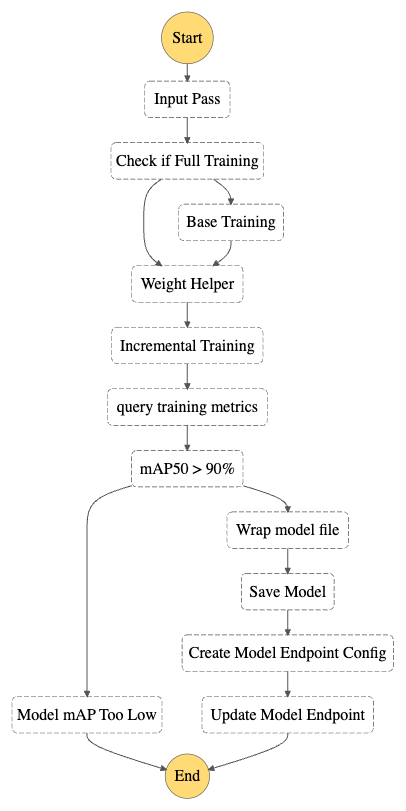

下面对pipeline中各个step做逐一的解释：
1. **input pass**: 将传入pipeline的input数据原封不动的传递给下一个step
2. **Check if full training**: 通过input传入的'IsFullTraining'参数判断，是否需要从基础训练开始，如果为false则跳过基础训练
3. **Base Training**: 进行基础训练
4. **Weight Helper**: 如果进行了基础训练，则weight helper会对基础训练的模型数据进行提取，得到best.pt文件并将其复制到增量训练数据的weight文件夹下；如果没有进行基础训练，weight helper则会检查增量训练数据的weight文件夹下是否有best.pt文件，如果没有，会复制一个best.pt过来
5. **Incremental Training**: 进行增量训练
6. **Query Training Metrics**: 通过Lambda检查增量训练的mAP50的结果并将其作为数据传递给下一个step
7. **mAP50 > 90%?**: 通过Choice Rule判断mAP50的结果是否满足我们的要求，如果不满足直接失败，如果满足则进入之后的模型部署step  
  7-a. **Model mAP too Low** 如果mAP低于阈值，则pipeling执行失败
8. **Model Wrapper**: 因为我们使用了自定义的inference.py文件，因此我们需要自己打包model并上传到inference实例
9. **Save Model**: 创建SageMaker模型对象
10. **Create Model Endpoint Config**: 创建SageMaker Endpoint Config对象
11. **Updata Endpoint**: 创建SageMaker Inference Endpoing

In [447]:
'''
完成初始化工作
'''
import uuid
import logging
import boto3
import sagemaker

# 通用的初始化
stepfunctions.set_stream_logger(level=logging.INFO)

# 生成uuid，用于唯一化各个组件需要用到的name
id = uuid.uuid4().hex

In [448]:
'''
引入step function sdk和后续需要用的模块
'''
import stepfunctions
from stepfunctions import steps
from stepfunctions.steps import TrainingStep, ModelStep, LambdaStep
from stepfunctions.inputs import ExecutionInput
from stepfunctions.workflow import Workflow
from stepfunctions.steps import Parallel, Choice, ChoiceRule, Fail

In [449]:
'''
定义传入step functions的input schema
调用pipeline的时候，需要传入如下的参数作为input
'''
execution_input = ExecutionInput(schema={
    'IsFullTraining': str,
    'BaseTrainingJobName': str,
    'BaseTrainingDataPath': str,
    'BestWeightsPath': str,
    'IncrementalTrainingJobName': str,
    'IncrementalTrainingDataPath': str,
    'InferenceCodePath': str,
    'ModelPath': str,
    'ModelName': str,
    'EndpointName': str,
})

In [450]:
'''
1. input pass: 
将传入pipeline的input数据原封不动的传递给下一个step
'''
input_pass_step = steps.states.Pass(
    'Input Pass',
    comment='Input Pass'
)

In [451]:
'''
2. Check if full training: 
通过input传入的'IsFullTraining'参数判断，是否需要从基础训练开始，如果为false则跳过基础训练
'''
check_full_step = steps.states.Choice(
    'Check if Full Training'
)

In [452]:
'''
3. Base Training: 
进行基础训练
'''
base_step = TrainingStep(
    'Base Training',
    estimator=base_estimator,
    data=execution_input['BaseTrainingDataPath'],
    job_name=execution_input['BaseTrainingJobName'],
    wait_for_completion=True,
    result_path='$.BaseTrainingResults'
)


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


In [453]:
'''
4. Weight Helper: 
提取best.pt文件，并保证增量训练数据中包含best.pt
'''

weight_helper_step = LambdaStep(
    'Weight Helper',
    parameters={  
        "FunctionName": "arn:aws:lambda:us-west-2:935206693453:function:weight-checker-HelloWorldFunction-sNu9tEaAbG1Q",
        "Payload":{  
               "inputs.$":"$"
            }
        },
    result_path='$.WeightHelperResult'
)

In [454]:
'''
5. Incremental Training: 
进行增量训练
'''
incremental_step = TrainingStep(
    'Incremental Training',
    estimator=incremental_estimator,
    data=execution_input['IncrementalTrainingDataPath'],
    job_name=execution_input['IncrementalTrainingJobName'],
    wait_for_completion=True,
    result_path='$.IncrementalTrainingResults'
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


In [455]:
'''
6. Query Training Metrics: 
通过Lambda检查增量训练的mAP50的结果并将其作为数据传递给下一个step
'''
query_training_metrics_step = LambdaStep(
    'query training metrics',
    parameters={  
        "FunctionName": "arn:aws:lambda:us-west-2:935206693453:function:query-training-metrics-HelloWorldFunction-3g01MUhfN0Rc",
        "Payload":{  
               "inputs.$":"$"
            }
        },
    result_path='$.QueryTrainingMetricsResult'
)

In [456]:
'''
7. mAP50 > 90%?: 
通过Choice Rule判断mAP50的结果是否满足我们的要求
'''
check_mAP50_step = steps.states.Choice(
    'mAP50 > 90%'
)

In [457]:
'''
7-a. Model mAP too Low: 
如果mAP低于阈值，则pipeling执行失败
'''
# 如果metrics不满足条件，那么整个流水线失败，需要创建一个Fail state
fail_step = steps.states.Fail(
    'Model mAP Too Low',
    comment='Validation mAP lower than threshold'
)

In [458]:
'''
8. Model Wrapper: 
打包model并上传到inference实例
'''
model_wrapper_step = LambdaStep(
    'Wrap model file',
    parameters={  
        "FunctionName": "arn:aws:lambda:us-west-2:935206693453:function:model-wrapper-HelloWorldFunction-f5JauhwQ0yqv",
        "Payload":{  
               "inputs.$":"$"
            }
        },
    result_path='$.ModelWrapperResult'
)

In [459]:
from sagemaker.pytorch.model import PyTorchModel

role = sagemaker.get_execution_role()

# inference instance type
instance_type = 'ml.m5.xlarge'

env={
    "TS_MAX_REQUEST_SIZE": str(100*1024*1024),
    # "SAGEMAKER_SUBMIT_DIRECTORY": "/opt/ml/model/code"
} 

# 创建sagemaker的模型对象
det_model = PyTorchModel(
                    model_data='s3://logo-detection-data/pipeline-exp-data/model/model.tar.gz', 
                    role=role,
                    sagemaker_session=sagemaker_session,
                    env=env,
                    entry_point='inference.py', 
                    framework_version='1.13.1', 
                    py_version='py39'
                )

In [460]:
'''
9. Save Model: 
创建SageMaker模型对象
'''
model_step = steps.ModelStep(
    'Save Model',
    model=det_model,
    model_name=execution_input['ModelName'],
    instance_type='ml.m5.xlarge',
    parameters={"PrimaryContainer": {"ModelDataUrl": model_wrapper_step.output()['ModelWrapperResult']['Payload']['ModelPath']}},
    result_path='$.ModelStepResults'
)

[INFO] Property: <ModelDataUrl> with value: <s3://logo-detection-data/pipeline-exp-data/model/model.tar.gz> will be overwritten with provided value: <<stepfunctions.inputs.placeholders.StepInput object at 0x7f97691be690>>


In [461]:
'''
10. Create Model Endpoint Config:
创建SageMaker Endpoint Config对象
'''
# 如果要对模型进行部署，需要定义模型部署的endpiont的配置，因此创建对应的step
endpoint_config_step = steps.EndpointConfigStep(
    "Create Model Endpoint Config",
    endpoint_config_name=execution_input['ModelName'],
    model_name=execution_input['ModelName'],
    initial_instance_count=1,
    instance_type='ml.m5.xlarge'
)

In [462]:
'''
11. Updata Endpoint:
创建SageMaker Inference Endpoing
'''
# 创建完配置后就需要真正的部署endpoint，创建对应的step
endpoint_step = steps.EndpointStep(
    'Update Model Endpoint',
    endpoint_name=execution_input['EndpointName'],
    endpoint_config_name=execution_input['ModelName'],
    update=False,
    result_path='$.EndpointResults'
)

In [463]:
'''
将之前创建好的step串联起来，我们从后往前进行串联
首先#7 step是一个choice step，如果满足条件会有创建endpoint分支，如果不满足会走失败的分支
'''
# 通过Chain组织起endpoint的分支
model_deploy_chain = steps.Chain([
    model_wrapper_step,
    model_step,
    endpoint_config_step,
    endpoint_step
])

# 在Choice step中需要定义rule，用于判断，从而选择下一步step是哪个
map50_threshold_rule = steps.choice_rule.ChoiceRule.NumericGreaterThan(variable=query_training_metrics_step.output()['QueryTrainingMetricsResult']['Payload']['trainingMetrics'][0]['Value'], value=.2)

# 添加choice，如果这个rule为真那么就走model_deploy_chain，否则就是fail step
check_mAP50_step.add_choice(rule=map50_threshold_rule, next_step=model_deploy_chain)
check_mAP50_step.default_choice(next_step=fail_step)

In [464]:
'''
再往上出现分支的step是#2，这一步判断是否需要全量训练（基础+增量）
如果需要全量训练会走一个分支，因此也需要对此分支进行Chain的操作
'''
full_chain = steps.Chain([
    base_step,
    weight_helper_step,
    incremental_step,
    query_training_metrics_step,
    check_mAP50_step
])

# 在Choice state中需要定义rule，用于判断，从而选择下一步step是哪个
boolean_rule = steps.choice_rule.ChoiceRule.StringEquals(variable=input_pass_step.output()['IsFullTraining'], value='True')

# 添加choice，如果这个rule为真那么就走全量训练，否则就是跳过基础训练进入weight helper
check_full_step.add_choice(rule=boolean_rule, next_step=full_chain)
check_full_step.default_choice(next_step=weight_helper_step)



In [465]:
'''
最后再把剩余的step串起来
'''
ml_chain = steps.Chain([
    input_pass_step,
    check_full_step
])

In [466]:
# 在IAM中创建一个step functions execution role并赋予sagemaker和lambda权限
workflow_execution_role = 'arn:aws:iam::935206693453:role/StepFunctionsWorkflowExecutionRole'

# 配置workflow
workflow = Workflow(
    name='FW-Det-Pipline-{}'.format(id),
    definition=ml_chain,
    role=workflow_execution_role,
    execution_input=execution_input
)

In [467]:
# 如果是创建workflow，请执行下面这个命令
# workflow.create()

# 更新现有的workflow
state_machine_arn = 'arn:aws:states:us-west-2:935206693453:stateMachine:FW-Det-Pipline-20b23e3733e0424ab75c3b677f05f407'
workflow = Workflow.attach(state_machine_arn)
workflow.update(ml_chain)

[INFO] Workflow updated successfully on AWS Step Functions. All execute() calls will use the updated definition and role within a few seconds. 


'arn:aws:states:us-west-2:935206693453:stateMachine:FW-Det-Pipline-20b23e3733e0424ab75c3b677f05f407'

In [438]:
execution = workflow.execute(
    inputs={
        'IsFullTraining': 'True',
        'BaseTrainingJobName': 'fw-det-base-job-{}'.format(id), # Each Sagemaker Job requires a unique name,
        'IncrementalTrainingJobName': 'fw-det-incremental-job-{}'.format(id),
        'BaseTrainingDataPath': 's3://logo-detection-data/pipeline-exp-data/LogoDet-3K/',
        'IncrementalTrainingDataPath': 's3://logo-detection-data/pipeline-exp-data/FreeWheel-5K-by-video-name/',
        'BestWeightsPath': 's3://logo-detection-data/pipeline-exp-data/best-weights/',
        'InferenceCodePath': 's3://logo-detection-data/pipeline-exp-data/inference/',
        'ModelPath': 's3://logo-detection-data/pipeline-exp-data/model/',
        'ModelName': 'fw-det-pipeline-model-{}'.format(id),
        'EndpointName': 'fw-det-pipeline-endpoint-{}'.format(id)
    }
)

[INFO] Workflow execution started successfully on AWS Step Functions.


## 4. 测试Endpoint

In [439]:
# 将endpoint替换为pipeline创建的endpoint name
predictor = sagemaker.predictor.Predictor(endpoint_name="fw-det-pipeline-endpoint-8a093f33828c44b5a7b591735d8ef5cb",
                                          sagemaker_session=sagemaker_session,
                                          serializer=sagemaker.serializers.NumpySerializer()
                                         )

In [441]:
import cv2

# 通过opencv将图片转换成numpy array用于推理
image = cv2.imread('image_sample/ABC_Chicago.jpg')

# print('image:', type(image), image.shape, image.dtype)
outputs = predictor.predict(image)
print('outputs: ', outputs)

outputs:  b'[{"boxes": [[0.37656617164611816, 0.11119751632213593, 0.133263498544693, 0.09143630415201187]], "confs": [0.5240346789360046], "classes": [48.0]}]'
